# Set up Parameters

In [6]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import numpy as np

train_path = "D:/Graduate Class/implement practice/PyTorch/dataset/MNIST/train"
test_path = "D:/Graduate Class/implement practice/PyTorch/dataset/MNIST/test"
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transforms = transforms.ToTensor()
train_ds = MNIST(train_path, train=True, download=True, transform=transforms)
test_ds = MNIST(test_path, train=False, download=True, transform=transforms)

# Show MNIST Dataset

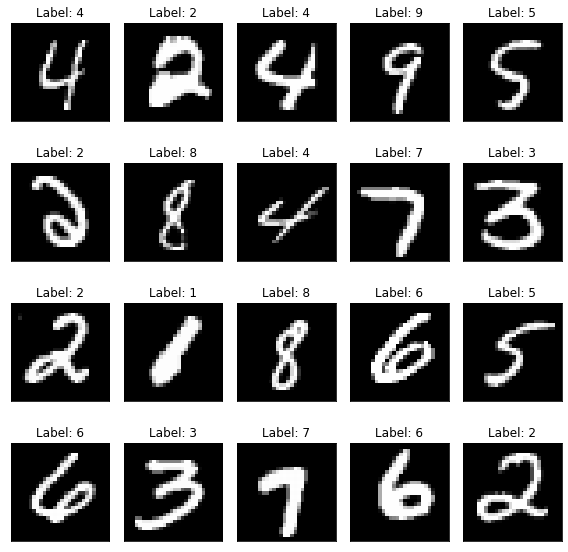

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import random

# axs is a 4x5 array
# after axs.flatten, it will be flatten a 1-dimension array (把4x5的子圖矩陣攤平)
fig, axs = plt.subplots(4, 5, figsize=(8,8))
for ax in axs.flatten(): # 20times
    img, label = random.choice(train_ds) # img is "PIL.Image.Image", label is "int"
    ax.imshow(np.array(img), cmap="gist_gray")
    ax.set_title(f"Label: {label}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Construct DataLoader

1. split 20% data as validation set
2. split data by random_split, like train_test_split in scikit-learn
3. reference: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

In [2]:
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import DataLoader

# convert to tensor
#train_ds.transforms = transforms.ToTensor()
#test_ds.transforms = transforms.ToTensor()

# split data
# in old version, random_split must input integer length whose sum must equal dataset
# in new version, random_split also can input fraction
length = len(train_ds)
lower, upper= int(length * (1-0.2)), int(length*0.2)
train_data, val_data = random_split(train_ds, [lower, upper])


train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Define Model (include encoder and decoder)

1. reference: https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html

In [10]:
from torch import nn

# encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # convolution
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(inplace=True)
            )
        
        # flatten
        self.flatten = nn.Flatten(start_dim=1) # output size = [batch, 32*3*3]

    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

# decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
            
        # unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
            
        # transpose convolution
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
            )
        
    def forward(self, x):
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    

# Construct Model

In [11]:
from torch import optim


torch.manual_seed(0)           # random seed
criterion = torch.nn.MSELoss() # loss
lr = 0.001                     # learning rate

# autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# optimizer
params_to_optim = [{"params": encoder.parameters()}, {"params": decoder.parameters()}]
optim = optim.Adam(params_to_optim, lr=lr)

# Define Noisy Function
1. about randn_like: https://pytorch.org/docs/stable/generated/torch.randn_like.
2. about torch.clip: https://pytorch.org/docs/stable/generated/torch.clamp.html#torch.clamp

In [12]:
def add_noisy(inputs, noise_factor=0.3):
    noise = inputs + torch.randn_like(inputs) * noise_factor
    noise = torch.clip(noise, 0, 1)
    return noise


# Define Training and Testing Function
1. about torch.cat: https://pytorch.org/docs/stable/generated/torch.cat.html?highlight=torch+cat#torch.cat

In [13]:
import numpy as np

def training_fn(encoder, decoder, dataloader, criterion, optimizer, noise_factor=0.3):
    
    # training phase
    encoder.train()
    decoder.train()
    train_loss = []
    
    for data, _ in dataloader:
        # add noisy
        data_noisy = add_noisy(data, noise_factor)
        data_noisy = data_noisy.to(device)
        
        # encoder and decoder
        encoder_output = encoder(data_noisy)
        decoder_output = decoder(encoder_output)
        
        loss = criterion(decoder_output, data_noisy)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy()) # escape gradient descent, convert to CPU, convert to numpy
        
    return np.mean(train_loss)

def testing_fn(encoder, decoder, dataloader, criterion, optimizer, noise_factor=0.3):
        
    # evaluating phase
    encoder.eval()
    decoder.eval()

    with torch.no_grad(): # do not need to track gradient
        count_out = []
        count_lbl = []
            
        for data, _ in dataloader:
            # add noisy
            data_noisy = add_noisy(data, noise_factor)
            data_noisy = data_noisy.to(device)
                
            # encoder and decoder
            encoder_output = encoder(data_noisy)
            decoder_output = decoder(encoder_output) # shape = [batch, C, H, W]
                
            count_out.append(decoder_output.cpu()) # [[b, C, H, W], [b, C, H, W], ...]
            count_lbl.append(data_noisy.cpu())     # [[b, C, H, W], [b, C, H, W], ...]
                
        # concact
        count_out = torch.cat(count_out) # [[C, H, W], [C, H, W], [C, H, W], ...]
        count_lbl = torch.cat(count_lbl) # [[C, H, W], [C, H, W], [C, H, W], ...]
            
        loss = criterion(count_out, count_lbl)
            
        return loss.data
                   

# Visualization

In [14]:
import matplotlib.pyplot as plt

def plot_ae_output(epoch, encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    
    for i in range(n): # reveal first n number
        ax = plt.subplot(3, n, i+1)
        img = test_ds[i][0].unsqueeze(0) # shape: [C, H, W] -> [Batch, C, H, W]
        
        img_noisy = add_noisy(img, noise_factor)
        img_noisy = img_noisy.to(device)
        
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad(): # do not need to track gradient descent
            rec_img = decoder(encoder(img_noisy))
        
        # show original and noisy image once
        if epoch == 0:
            # original image
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title("Original")
            
            # noisy image
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title("Noisy")
            
        # show reconstruction image
        if epoch == 0:
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n // 2:
                ax.set_title("Reconstruction")
        else:
            ax = plt.subplot(3, n, i+1)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
    
    plt.show()


# Train and Validation

Epoch: 1/30 	 Train Loss: 0.098 	 Val Loss: 0.049


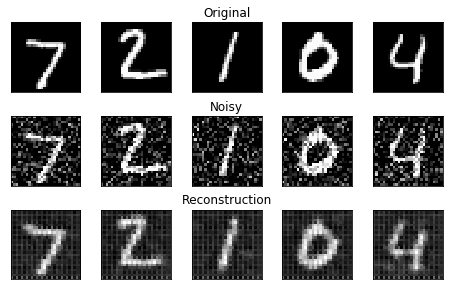

Epoch: 2/30 	 Train Loss: 0.040 	 Val Loss: 0.034


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


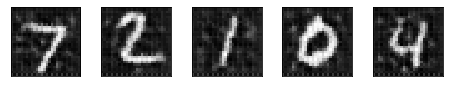

Epoch: 3/30 	 Train Loss: 0.032 	 Val Loss: 0.030


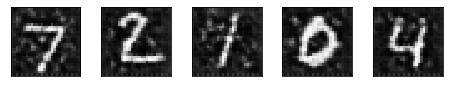

Epoch: 4/30 	 Train Loss: 0.029 	 Val Loss: 0.028


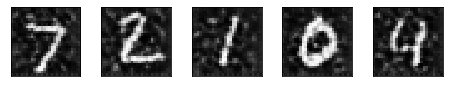

Epoch: 5/30 	 Train Loss: 0.027 	 Val Loss: 0.027


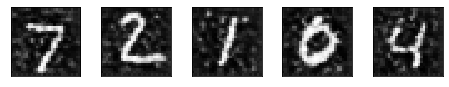

Epoch: 6/30 	 Train Loss: 0.026 	 Val Loss: 0.026


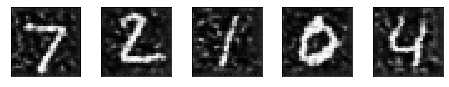

Epoch: 7/30 	 Train Loss: 0.025 	 Val Loss: 0.025


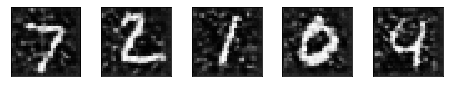

Epoch: 8/30 	 Train Loss: 0.025 	 Val Loss: 0.025


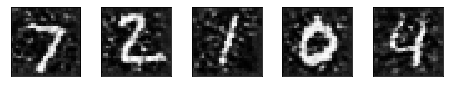

Epoch: 9/30 	 Train Loss: 0.025 	 Val Loss: 0.024


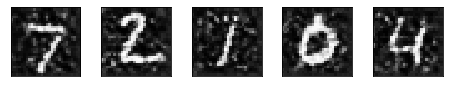

Epoch: 10/30 	 Train Loss: 0.024 	 Val Loss: 0.024


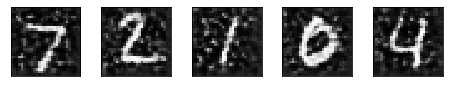

Epoch: 11/30 	 Train Loss: 0.024 	 Val Loss: 0.024


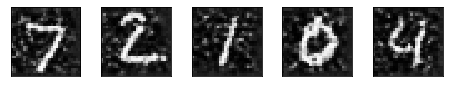

Epoch: 12/30 	 Train Loss: 0.023 	 Val Loss: 0.023


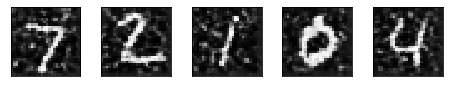

Epoch: 13/30 	 Train Loss: 0.023 	 Val Loss: 0.023


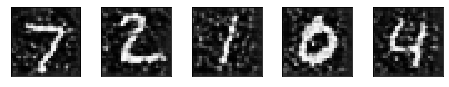

Epoch: 14/30 	 Train Loss: 0.023 	 Val Loss: 0.023


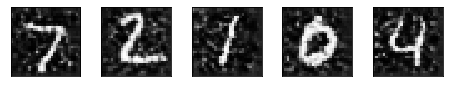

Epoch: 15/30 	 Train Loss: 0.023 	 Val Loss: 0.023


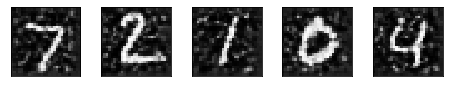

Epoch: 16/30 	 Train Loss: 0.023 	 Val Loss: 0.022


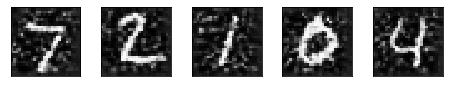

Epoch: 17/30 	 Train Loss: 0.022 	 Val Loss: 0.022


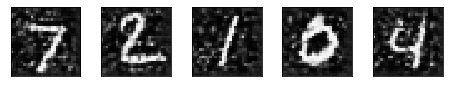

Epoch: 18/30 	 Train Loss: 0.022 	 Val Loss: 0.022


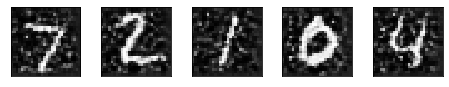

Epoch: 19/30 	 Train Loss: 0.022 	 Val Loss: 0.022


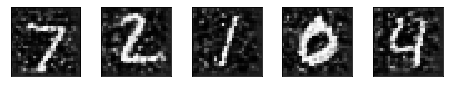

Epoch: 20/30 	 Train Loss: 0.022 	 Val Loss: 0.022


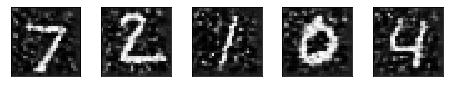

Epoch: 21/30 	 Train Loss: 0.022 	 Val Loss: 0.022


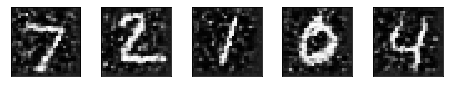

Epoch: 22/30 	 Train Loss: 0.022 	 Val Loss: 0.022


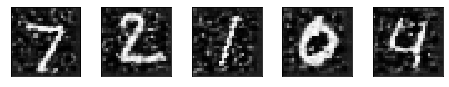

Epoch: 23/30 	 Train Loss: 0.022 	 Val Loss: 0.022


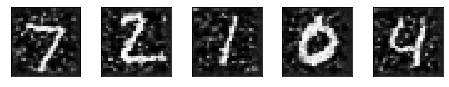

Epoch: 24/30 	 Train Loss: 0.022 	 Val Loss: 0.021


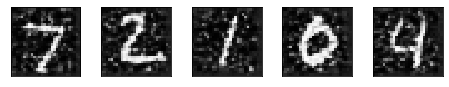

Epoch: 25/30 	 Train Loss: 0.021 	 Val Loss: 0.021


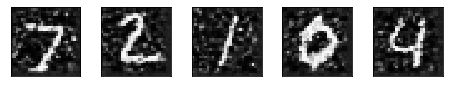

Epoch: 26/30 	 Train Loss: 0.021 	 Val Loss: 0.021


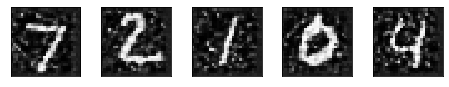

Epoch: 27/30 	 Train Loss: 0.021 	 Val Loss: 0.021


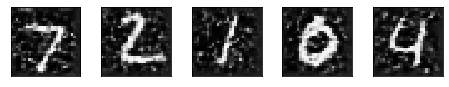

Epoch: 28/30 	 Train Loss: 0.021 	 Val Loss: 0.021


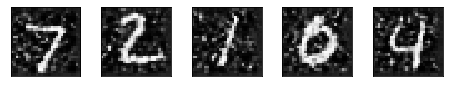

Epoch: 29/30 	 Train Loss: 0.021 	 Val Loss: 0.021


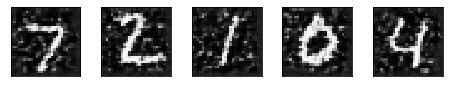

Epoch: 30/30 	 Train Loss: 0.021 	 Val Loss: 0.021


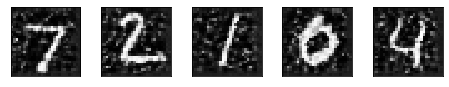

In [15]:
noise_factor = 0.3
epochs = 30
history_loss = {"train_loss": [], "val_loss": []}

for epoch in range(epochs):
    # train
    train_loss = training_fn(encoder=encoder, decoder=decoder, dataloader=train_dl, criterion=criterion,
                             optimizer=optim, noise_factor=noise_factor)
    # validation
    val_loss = testing_fn(encoder=encoder, decoder=decoder, dataloader=val_dl, criterion=criterion,
                          optimizer=optim, noise_factor=noise_factor)
    # print
    history_loss["train_loss"].append(train_loss)
    history_loss["val_loss"].append(val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} \t Train Loss: {train_loss:.3f} \t Val Loss: {val_loss:.3f}")
    
    plot_ae_output(epoch, encoder, decoder, noise_factor=0.3)

In [16]:
loss = testing_fn(encoder, decoder, test_dl, criterion, optimizer=optim, noise_factor=0.3)
print(f"Loss of Testing: {loss}")

Loss of Testing: 0.020998146384954453


# Observe Latent Factor(output of encoder)

In [17]:
import pandas as pd

encoder_samples = [] # used to save dictionary

for data in test_ds:
    img = data[0].unsqueeze(0).to(device) # [C, H, W] -> [batch, C, H, W]
    label = data[1]
    
    encoder.eval()
    with torch.no_grad():
        output = encoder(img) # latent factor
    
    z_code = output.flatten().cpu().numpy() # [batch, 4] -> [4]
    row = {f"variable {i+1}": variable for i, variable in enumerate(z_code)}
    row["Label"] = label
    encoder_samples.append(row)

table = pd.DataFrame(encoder_samples)
table


,variable 1,variable 2,variable 3,variable 4,variable 5,variable 6,variable 7,variable 8,variable 9,variable 10,...,variable 280,variable 281,variable 282,variable 283,variable 284,variable 285,variable 286,variable 287,variable 288,Label
0,0.704227,0.532384,0.132734,0.110443,0.677826,0.335519,0.146047,0.307812,0.228275,0.989149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,0.554052,1.196426,0.199738,0.450447,0.000000,0.123139,0.105466,0.476190,0.087694,0.703623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.136289,0.606919,0.327687,0.139027,0.564211,0.227035,0.167088,0.202439,0.185019,0.717162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.235771,1.457087,0.177776,0.834609,0.572791,0.519719,0.077905,0.232046,0.320706,0.603671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.301127,0.012803,0.315939,0.890174,0.513115,0.175294,0.115304,0.586233,0.144146,0.550831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.949764,1.059444,0.015333,0.096427,1.161905,0.301315,0.641914,0.223838,0.303245,1.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
9996,0.891989,1.268895,0.218288,0.050012,0.422141,0.126063,0.185055,0.777041,0.256387,0.983248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9997,0.191993,0.447267,0.208216,0.243803,1.589006,0.278969,0.130399,0.082093,0.213398,0.666113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9998,0.122918,0.576603,0.740496,0.423338,1.121102,0.072624,0.023970,0.000000,0.205355,0.726520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


# Randomly Generate Image

In [18]:
def plot_reconstruction(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20, 8.5))
    h, w = 28, 28
    img = np.zeros((n*h, n*w)) # in PyTorch is (C, H, W)
                                 # but in matplotlib is (H, W, C)
    
    for i, y in enumerate(np.linspace(*r1, n)):      # hight
        for j, x in enumerate(np.linspace(*r0, n)):  # weight
            z = torch.tensor([[x, y],
                              [x, y]])
            #print(z[0, 0].dtype) -> float64
            
            ###### warning ######
            # by default, dtype of numpy is float-64
            # but dtype of PyTorch is float-32
            #####################
            z = z.float()
            z_reshape = z.reshape(-1, 4).to(device) # shape: [2, 2] -> [1, 4]
            x_hat = decoder(z_reshape)
            x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
            
            # plot
            img[(n-1-i)*h:(n-1-i+1)*h, (j)*w:(j+1)*w] = x_hat # 順序: 由左至右, 由上至下
            #img[(i)*h:(i+1)*h, (j)*w:(j+1)*w] = x_hat        # 順序: 由左至右, 由下至上
    plt.imshow(img, extent=[*r0, *r1], cmap="gist_gray")

plot_reconstruction(decoder, r0=(-1, 1), r1=(-1, 1))

RuntimeError: unflatten: Provided sizes [32, 3, 3] don't multiply up to the size of dim 1 (4) in the input tensor

<Figure size 1440x612 with 0 Axes>